In [1]:
import slax as sl
import flax.linen as nn
import jax.numpy as jnp
import jax
import optax
import pickle
from jax.tree_util import tree_map, Partial, tree_leaves, tree_structure, tree_unflatten
import matplotlib.pyplot as plt

In [2]:
input_sz = 50
output_sz = 10
seq_len = 10
manifold_key = jax.random.PRNGKey(0)
random_seed = manifold_key
key = manifold_key
batch_sz = 128
dtype = jnp.float32
x = jnp.ones((2,10,5))

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 48.00 GB
maxCacheSize: 18.00 GB



2024-01-29 09:05:42.379932: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [3]:
batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,dtype=dtype)

In [4]:
m = nn.RNN(sl.LIF(trainable_tau=True))
p = m.init(key,batch[0])
out = m.apply(p,batch[0])

In [5]:
m = sl.LIF(trainable_tau=True)
c = m.initialize_carry(key,batch[0][0].shape)
p = m.init(key,c,batch[0][0])

In [6]:
snn = sl.connect([nn.Dense(100,dtype=dtype,param_dtype=dtype),
                  sl.LIF(0.7,spike_fn=sl.fast_sigmoid(10)),
                  nn.Dense(10,dtype=dtype,param_dtype=dtype),
                  sl.LIF(jnp.ones(output_sz,dtype)*0.2,spike_fn=sl.fast_sigmoid(10),trainable_tau=True)],)

In [7]:
OSTL_snn = sl.connect([sl.DenseOSTL([nn.Dense(100,dtype=dtype,param_dtype=dtype),
                  sl.LIF(0.7,spike_fn=sl.fast_sigmoid(10))]),
                  sl.DenseOSTL([nn.Dense(10,dtype=dtype,param_dtype=dtype),
                  sl.LIF(jnp.ones(output_sz,dtype)*0.2,spike_fn=sl.fast_sigmoid(10),trainable_tau=True)])],)

In [8]:
bp_model = snn
bp_params = bp_model.init(key,jnp.zeros_like(batch[0]))

In [9]:
ostl_model = OSTL_snn
ostl_params = ostl_model.init(key,jnp.zeros_like(batch[0][0]))
ostl_params['params'] = tree_unflatten(tree_structure(ostl_params['params']),tree_leaves(bp_params['params']))

In [10]:
optimizer = optax.adamax(0.01)
bp_opt_state = optimizer.init(tree_map(jnp.float32,bp_params['params']))
ostl_opt_state = optimizer.init(tree_map(jnp.float32,ostl_params['params']))

In [11]:
def exec(bp_params,bp_opt_state,ostl_params,ostl_opt_state,random_seed):
    random_seed,val_seed = jax.random.split(random_seed)
    new_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    bp_params,bp_opt_state,bp_s,bp_loss,bp_grad = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)(bp_params,new_batch,bp_opt_state)
    train_func = sl.train_online(ostl_model,optax.softmax_cross_entropy,optimizer)
    ostl_params,ostl_opt_state,s,ostl_loss = train_func(ostl_params,new_batch,ostl_opt_state)

    val_batch = sl.randman(manifold_key,val_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    _,_,ostl_s,ostl_loss,_ = sl.train_online_deferred(ostl_model,optax.softmax_cross_entropy,optimizer)(ostl_params,val_batch,ostl_opt_state)
    _,_,bp_s,bp_loss,_ = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)(bp_params,val_batch,bp_opt_state)

    return bp_params,bp_opt_state,ostl_params,ostl_opt_state,random_seed,bp_loss,jnp.mean(ostl_loss)

In [12]:
with open('./tmp/bp_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
best_bp_loss = 100
best_ostl_loss = 100
best_bp_params = bp_params
best_ostl_params = ostl_params
for i in range(1_000):
    bp_params,bp_opt_state,ostl_params,ostl_opt_state,random_seed,bp_loss,ostl_loss = jax.jit(exec)(bp_params,bp_opt_state,ostl_params,ostl_opt_state,random_seed)
    if bp_loss < best_bp_loss:
        best_bp_params = bp_params
    if ostl_loss < best_ostl_loss:
        best_ostl_params = ostl_params
    if (i+1) % 1_00 == 0:
        with open('./tmp/bp_model_{}'.format((i+1)//1_00),'wb') as file:
            pickle.dump(tree_map(jnp.float32,bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ostl_model_{}'.format((i+1)//1_00),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/bp_model_{}'.format((i+1)//1_000),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format((i+1)//1_000),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

    


In [14]:
struct = tree_structure(bp_params['params'])

In [15]:
test_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,dim_manifold=2,alpha=2.)
bp_test_carry = bp_model.init(key,jnp.zeros_like(test_batch[0][0]))
bp_test_params = bp_params
bp_test_params['carry'] = bp_test_carry['carry']

In [16]:
def apply(params,x):
    s,upd = bp_model.apply(params,x,mutable='carry')
    params.update(upd)
    return params,s

In [17]:
def get_loss(params):
    _,s = jax.lax.scan(apply,params,test_batch[0])
    return jnp.mean(optax.softmax_cross_entropy(s,test_batch[1]))

In [18]:
def load_params(number):
    with open('./tmp/bp_model_{}'.format(number),'rb') as file:
        bp_params = pickle.load(file)
    bp_params['carry'] = bp_test_carry['carry']
    with open('./tmp/ostl_model_{}'.format(number),'rb') as file:
        ostl_params = pickle.load(file)
    ostl_params['params'] = tree_unflatten(struct,tree_leaves(ostl_params['params']))
    ostl_params['carry'] = bp_test_carry['carry']
    return [bp_params,ostl_params][::-1]

In [19]:
get_loss(load_params(10)[0])

Array(1.6680613, dtype=float32)

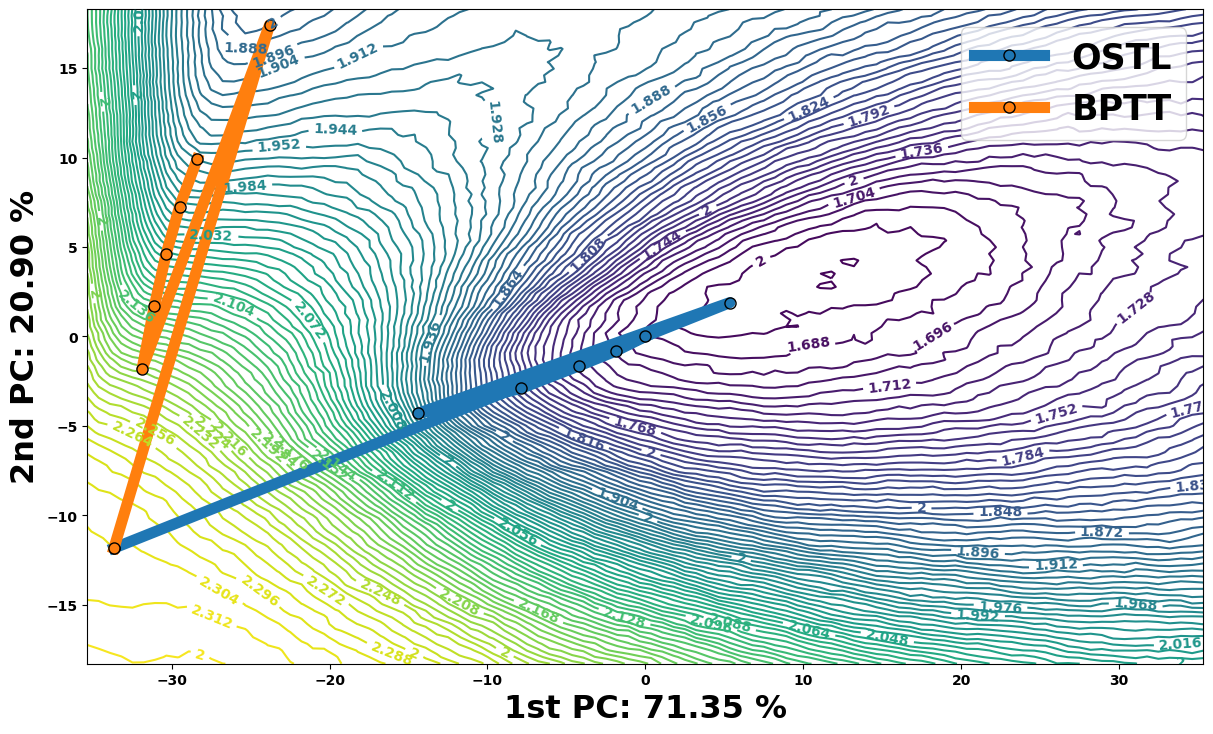

In [20]:
sl.gen_loss_landscape(get_loss,load_params,7,2)
plt.legend(['BPTT','OSTL'][::-1],fontsize=25)